In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
from os.path import join, basename, isfile

from hydromt_wflow import WflowModel
from hydromt.config import configread
from hydromt.log import setuplog
from hydromt import DataCatalog
import numpy as np
import yaml

root = r'../models/wflow'
data_libs=[r'../data/wflow_data/data_catalog.yml']

## 1 prepare ERA5 and CHIRPS based forcing  

In [2]:
# overview of data used for setting up the static SFINCS layers
data_catalog = DataCatalog(data_libs)
wf_data = ['era5_daily', 'era5_orography', 'chirps']
data_cols = ['category', 'paper_doi', 'paper_ref', 'source_url', 'source_version','notes']
data_catalog.to_dataframe().loc[wf_data, data_cols]

,category,paper_doi,paper_ref,source_url,source_version,notes
era5_daily,meteo,10.1002/qj.3803,Hersbach et al. (2019),https://doi.org/10.24381/cds.bd0915c6,ERA5 daily data on pressure levels,Extracted from Copernicus Climate Data Store; ...
era5_orography,meteo,10.1002/qj.3803,Hersbach et al. (2019),https://doi.org/10.24381/cds.bd0915c6,NaN,Extracted from Copernicus Climate Data Store
chirps,meteo,10.1038/sdata.2015.66,Funk et al (2015),https://www.chc.ucsb.edu/data/chirps,v2.0,NaN


In [3]:
# configuration file
wf_config = configread('wflow_update_forcing.yml')
print(yaml.dump(wf_config, sort_keys=False))

setup_config:
  starttime: 2017-09-01 00:00:00
  endtime: 2019-03-31 00:00:00
  timestepsecs: 86400
  input.path_forcing: inmaps-era5.nc
  dir_output: run_era5
setup_precip_forcing:
  precip_fn: era5_daily
setup_temp_pet_forcing:
  temp_pet_fn: era5_daily
  press_correction: true
  temp_correction: true
  dem_forcing_fn: era5_orography
  pet_method: debruin
  skip_pet: false
write_forcing:
  freq_out: AS
write_config:
  config_name: run_era5.toml



In [ ]:
# initialize WflowModel class model previously build model.  
for forcing in ['era5_daily', 'chirps']:
    wf = WflowModel(
        root = root,
        mode='r+', # open in append mode
        data_libs=data_libs, # link to data catalog
        logger=setuplog('wflow'), 
    )
    # remove default gridded ouput, we are only interested in the point output
    wf.config.pop('output', None)
    # update confing based on forcing
    name = forcing.split('_')[0]
    wf_config['setup_config'].update({'input.path_forcing': f'inmaps-{name}.nc', 'dir_output': f'run_{name}'})
    wf_config['setup_precip_forcing'].update({'precip_fn': forcing})
    wf_config['write_config'].update({'config_name': f'run_{name}.toml'})
    # TODO: this is a bit hacky, we should 
    # remove any write_config methods inside other WflowModel methods
    # always execute write_config last
    wf._config_fn = wf_config['write_config']['config_name']
    
    # prepare and write forcing
    wf.update(opt=wf_config)

## 2 Define and run model simulations

### 2A Define simulations

In [5]:
import datetime
# combine era5 and chirps precip forcing with different landuse base maps
# each run requires a different toml file

runs = ['run_chirps.toml', 'run_era5.toml', ]

for run in runs[:2]:
    name = run.replace('.toml', '')
    run2 = f'{name}_vito.toml'
    wf = WflowModel(root, mode='r+', config_fn=run)
    wf.read_config()
    # wf.setup_config(**{'starttime': datetime.datetime(2019, 3, 1)}) # shorter test run
    wf.setup_config(**{'starttime': datetime.datetime(2017, 9, 2)}) # full run
    wf.write_config()
    # run with vito landuse
    wf.setup_config(**{
        'input.path_static': 'staticmaps_vito.nc',
        'dir_output': f'{name}_vito'
    })
    wf.write_config(run2)
    runs.append(run2)

print(runs)

Model dir already exists and files might be overwritten: c:\Users\eilan_dk\project_data\hydromt-wflow-sfincs\models\wflow\staticgeoms.


['run_chirps.toml', 'run_era5.toml', 'run_chirps_vito.toml', 'run_era5_vito.toml']


### 2B run simulations

Wflow is an open source julia package and also provided as an compiled executable. Here we used the windows executable v0.6.3.
Note that this is not included in the repository. Please visit the ["How to Install" section of the Wflow.jl docs](https://deltares.github.io/Wflow.jl/dev/user_guide/install/) for more info about how to get and install Wflow.

In [6]:
import subprocess, os
from data import copyfile
import shutil

# if you don't have the Wflow executable in the bin folder
# the model results will be downloaded from zenodo

exe = r'../bin/wflow_cli/bin/wflow_cli.exe'

if isfile(exe):
    # this should take approx ~10 min per simulation
    my_env = os.environ.copy()
    my_env['JULIA_NUM_THREADS'] = '2'

    for run in runs:
        print(run)
        subprocess.run([exe, join(root, run)], check=True, env=my_env)
else:
    src = f'https://zenodo.org/record/7858596/files/wflow_results.zip'
    dst = join("../models/wflow/", basename(src))
    if not isfile(dst):
        copyfile(src, dst)
        shutil.unpack_archive(dst, "../models/wflow/")

run_chirps.toml
run_era5.toml
run_chirps_vito.toml
run_era5_vito.toml


### 2C create a data catalog yml file with all simulation results

In this step we create a data catalog with the csv output of all Wflow runs.
This data catalog can be used by HydroMT-SFINCS to setup the discharge boundary conditions.

In [7]:
from copy import deepcopy
# create/update a data catalog yml with all wflow output
fn_wflow_data = join(root, 'wflow.yml')
if isfile(fn_wflow_data):
    with open(fn_wflow_data, 'r') as f:
        wflow_yml = yaml.load(f, Loader=yaml.FullLoader)
else:
    wflow_yml = {}

wf = WflowModel(root=root, mode='r')
wf.read_staticgeoms()
name = 'gauges_sfincs'

rename = {f'Q_{i:d}': int(i) for i in wf.geoms[name]['index'].values}
wflow_output = {
    'data_type': 'DataFrame',
    'driver': 'csv',
    'kwargs': {'index_col': 0, 'parse_dates': True, 'usecols': ['time'] + list(rename.keys())},
    'rename': rename,
    'meta': {'category': 'discharge'}
}

for run in runs:
    item0 = deepcopy(wflow_output)
    wf = WflowModel(root=root, mode='r', config_fn=run)
    item0['path'] = join(wf.config['dir_output'], wf.config['csv']['path'])
    item0['meta'].update({'notes': f'Wflow model output at {name} for {basename(run)}'})
    fn = f"wflow_{basename(run).split('.')[0]}"
    wflow_yml[fn] = item0

with open(fn_wflow_data, 'w') as f:
    yaml.dump(wflow_yml, f, sort_keys=False)

##  3. Analyze results

In [8]:
runs = ['run_chirps.toml', 'run_era5.toml', 'run_chirps_vito.toml', 'run_era5_vito.toml']

In [15]:
# read results and precip
q_out = {}
precip = {}
sfincs_gauge = 2
for run in runs:
    name = run.split('.')[0].replace('run_', '')
    wf = WflowModel(root=root, config_fn=run, mode='r')
    q_out[name] = wf.results['Q_gauges_sfincs'].sel(index=sfincs_gauge).squeeze()
    if 'vito' not in name: # only single landuse required 
        # use subcatch mean precip from results
        subcatch = wf.staticmaps['wflow_subcatch_sfincs'] == sfincs_gauge
        precip[name] = wf.forcing['precip'].where(subcatch).mean(['lat', 'lon'])

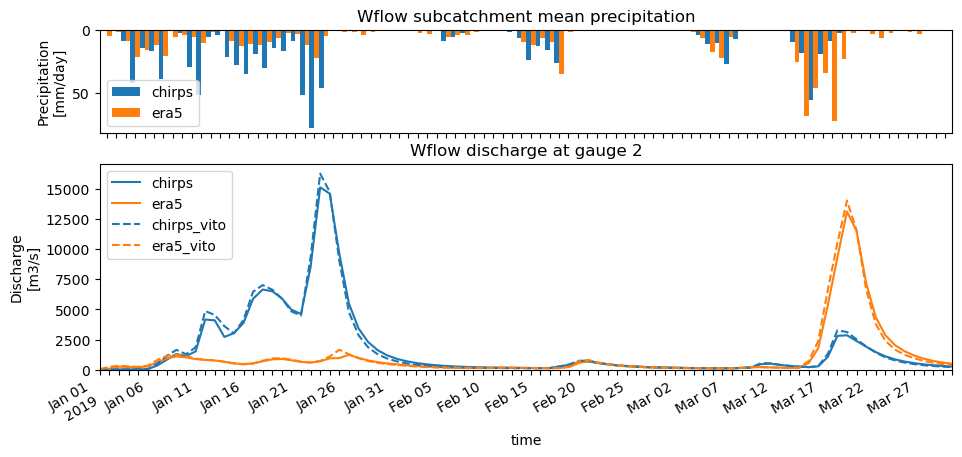

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

tslice = slice('2019-01-01', '2019-03-31')

# merge precip data
dfs = []
for p in precip:
    dfs.append(precip[p].sel(time=tslice).to_series().rename(p))
df_precip = pd.concat(dfs, axis=1)


# merge discharge data
dfs = []
for name in q_out:
    dfs.append(q_out[name].sel(time=tslice).to_series().rename(name))
df_discharge = pd.concat(dfs, axis=1)
# make sure time axes align
df_precip = df_precip.reindex(df_discharge.index, method='nearest')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]

fig, (ax, ax1) = plt.subplots(2,1, figsize=(11, 5), gridspec_kw={'height_ratios': [1, 2]})#, sharex=True)
# plot precip
df_precip.plot.bar(ax=ax, width=1, color=colors)
ax.set_title('Wflow subcatchment mean precipitation')
ax.set_ylabel('Precipitation\n[mm/day]')
ax.invert_yaxis()
ax.legend(loc='lower left')

# plot response
df_discharge.iloc[:,:2].plot(ax=ax1, color=colors, ls='-')
df_discharge.iloc[:,2:].plot(ax=ax1, color=colors, ls='--')
ax1.set_title(f'Wflow discharge at gauge {sfincs_gauge}')
ax1.set_ylim([0, df_discharge.max().max()*1.05])
ax1.set_ylabel('Discharge\n[m3/s]')
ax1.legend(loc='upper left')

# Make most of the ticklabels empty so the labels don't get too crowded
index = df_discharge.index
ticklabels = ['']*len(index)
# Every 4th ticklable shows the month and day
ticklabels[::5] = [item.strftime('%b %d') for item in index[::5]]
# first ticklabel includes the year
ticklabels[0] = index[0].strftime('%b %d\n%Y')
ax1.set_xticks(index)
ax1.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.minorticks_off()
plt.gcf().autofmt_xdate()
fig.savefig(join(root, f'wflow_sim_guage{sfincs_gauge}.png'), dpi=450, bbox_inches='tight')